# Capstone Project - Machine Learning Nanodegree

## Convolutional Neural Networks - Thorax-Pneumonia Classifier

---

### Introduction

In this notebook, we are developing a deep learning classification algorithm. Specific models learn a mapping between input features and class labels. The coding shall accept any future (posterior-anterior, anterior-posterior orientations) X-ray chest image as input for estimation of having a pneumonia chest image or not. Regarding the underlying dataset, we are solving such binary classification question for .jpgeg compressed X-ray chest images mostly from children. This dataset used for analysis comes from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/version/2). Such kind of analysis result improves the medical diagnostic workflow. As a future improvement, the algorithm could be used for all human age categories and X-ray orientations including lateral chest images, but such images are not available by now.

![Image Samples](images/lung_images_pair_small.PNG)


For official companies the medical software development happened as part of a regulatory domain. So, let us assume, we would like to use the algorithm as a component of an official product. Then notified bodies would proof the algorithm and its concept regarding quality and regulatory aspects. From technical point of view, working with medical images the CNN concept is the state-of-the-art approach. On the other hand, for getting an official permission and its discussion, the comparison and benchmark of several network architectures and parameter changes together with explanations would help. So, let us do this now.


For implementation on Windows OS, we use Python 3.6 with Keras and TensorFlow as backend. For plotting the network architecture the pydot library and Graphviz2.38 shall be installed and properly configured (see [readme]()).

---

### Navigation Content

* [Step 0](#step0): Import Libraries and Reproducibility
* [Step 1](#step1): Import Chest Dataset
* [Step 2](#step2): Data Exploration
* [Step 3](#step3): Data Pre-Processing
* [Step 4](#step4): Create a CNN Model from the Scratch (Basic Model)
* [Step 5](#step5): Last Basic Model with Augmentation
* [Step 6](#step6): Such Basic Model with Adam as Optimiser
* [Step 7](#step7): Last Basic Model with Adam and Augmentation
* [Step 8](#step8): Create an improved CNN Model with Adam
* [Step 9](#step9): Last improved CNN Model with Augmentation
* [Step 10](#step10): Create a Batch CNN Model from the Scratch
* [Step 11](#step11): Create a CNN Model with Transfer Learning
* [Step 12](#step12): Benchmark and Conclusion


---
<a id='step0'></a>
## Step 0: Import Libraries and Reproducibility

### Import Libraries
Import libraries needed to implement the algorithm for this Chest image classifier. Finally, set random seed to make the results reproducible. Note: Message pops up that TensorFlow backend is used.

In [1]:
from sklearn.datasets import load_files 
from sklearn import metrics
from glob import glob
from tqdm import tqdm
from PIL import ImageFile

from keras.utils import np_utils, plot_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

from models.Model import Model

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt                        
%matplotlib inline 

import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
import pydot

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Using TensorFlow backend.


### Make the Code Reproducible 

According Keras documentation this additional coding is necessary to make the results reproducible.

In [2]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(1042)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

<a id='step1'></a>
## Step 1: Import Chest Dataset

In the code cell below, we import a dataset of chest images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `chest_names` - list of string-valued chest names (NORMAL, PNEUMONIA) for translating labels

In [3]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/chest_xray/train')
valid_files, valid_targets = load_dataset('data/chest_xray/val')
test_files, test_targets = load_dataset('data/chest_xray/test')

# load list of chest names (NORMAL, PNEUMONIA)
chest_names = [item[20:-1] for item in sorted(glob("data/chest_xray/train/*/"))]

<a id='step2'></a>
## Step 2: Data Exploration

Some statistical information about the dataset of chest images. 

In [4]:
# print statistics about the dataset
# print('There are {} total chest categories, called: {}, {}.'.format(len(chest_names),chest_names[0],chest_names[1]))
print('There are %d total chest categories.' % len(chest_names))  # there are only 2
print('There are %s total chest images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training chest images.' % len(train_files))
print('There are %d validation chest images.' % len(valid_files))
print('There are %d test chest images.'% len(test_files))

There are 2 total chest categories.
There are 5856 total chest images.

There are 4672 training chest images.
There are 32 validation chest images.
There are 1152 test chest images.


**Note:**<br>
According the original dataset 89.07% are training images and only 10.66% are test images. This doesn't fit to the rule-of-thumb to use a training/testing separation of 70/30 or 80/20 percent. Therefore, this distribution has been changed to the 80/20 ratio. Regarding the second separation of being normal or pneumonia ones (resp. root cause virus or bacteria), the same distribution ratio as before has been choosen. The images moved to the other directories have been selected randomly.

80% training images = 4684.8  => 4685  => division by 32: 146 x 32 = 4672; therefore in the new training set 4672 images are available<br>
20% test images = 1171.2,  but some are moved to the validation set now. In the original dataset no virus chest images are included to the validation set. Now there are some and some more bacteria chest images.


How are the categories labelled? Regarding the images, for the different training, testing and validation pneumonia data samples, the images are labelled with 'virus' and 'bacteria' as root cause. This information is part of the image name text string. How many are there from each root cause category? The categories are ...

In [5]:
# What kind of chest categories exist?
chest_names

['n\\NORMAL', 'n\\PNEUMONIA']

What is the structure of the files from the different directories, means how many images from each category are available in the train, validation and test directories?

In [6]:
def get_category_counter(file):
    ''' delivers the amount of normal or pneumonia images '''
    counter_normal = 0
    counter_pneumonia = 0
    file_array = file
    pneumonia_files = []
        
    for item in file_array[:]:
        if 'NORMAL' in item:
            counter_normal += 1
        else: # PNEUMONIA case
            # add item to array and increase counter
            pneumonia_files.append(item)
            counter_pneumonia += 1
               
    return counter_normal, counter_pneumonia, pneumonia_files

count_train_normal, count_train_pneumonia, train_pneumonia_files = get_category_counter(train_files)
count_valid_normal, count_valid_pneumonia, valid_pneumonia_files = get_category_counter(valid_files)
count_test_normal, count_test_pneumonia, test_pneumonia_files = get_category_counter(test_files)

print("--- Train files ---")        
print("{} normal chest images.".format(count_train_normal))
print("{} pneumonia chest images.".format(count_train_pneumonia))

print("\n--- Validation files ---")        
print("{} normal chest images.".format(count_valid_normal))
print("{} pneumonia chest images.".format(count_valid_pneumonia))

print("\n--- Test files ---")        
print("{} normal chest images.".format(count_test_normal))
print("{} pneumonia chest images.".format(count_test_pneumonia))

--- Train files ---
1144 normal chest images.
3528 pneumonia chest images.

--- Validation files ---
16 normal chest images.
16 pneumonia chest images.

--- Test files ---
423 normal chest images.
729 pneumonia chest images.


This is much clearer if visualised in bar charts.

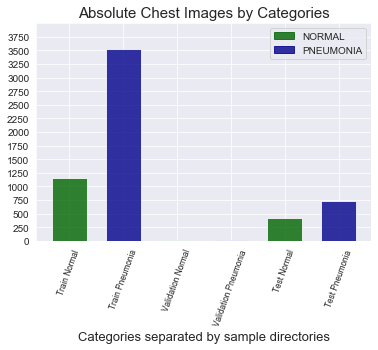

In [7]:
# Visualise all the findings
locations = [0, 1, 2, 3, 4, 5]
colors = ['darkgreen', 'darkblue', 'darkgreen', 'darkblue', 'darkgreen', 'darkblue']
hights = [count_train_normal, count_train_pneumonia, count_valid_normal, count_valid_pneumonia,
         count_test_normal, count_test_pneumonia]
width = 0.65
label_list = ['Train Normal', 'Train Pneumonia', 'Validation Normal', 'Validation Pneumonia',
              'Test Normal', 'Test Pneumonia']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.yticks(np.arange(0, 4000, 250))
labels = ax.set_xticklabels(label_list, rotation=70, fontsize='small')
plt.bar(locations, hights, width, color=colors, tick_label=labels, alpha=0.8)
plt.ylim([0, 4000])
plt.title('Absolute Chest Images by Categories', fontsize=15)
plt.xlabel('Categories separated by sample directories', fontsize=13)
green_patch = mpatches.Patch(color='darkgreen', label='NORMAL', alpha=0.8)
blue_patch = mpatches.Patch(color='darkblue', label='PNEUMONIA', alpha=0.8)
plt.legend(handles = [green_patch, blue_patch])

In [8]:
# For simpler usage, first we have to put the data in a dictionary.
# {'train' : {'Normal' : count_train_normal,
#             'Pneumonia' : count_train_pneumonia},
#  'valid' : {'Normal' : count_valid_normal,
#             'Pneumonia' : count_valid_pneumonia}, 
#  'test' : {'Normal' : count_test_normal, 
#            'Pneumonia' : count_test_pneumonia}}

categories_counter_data = {"Sample" : ["train", "valid", "test"],
                           "Normal" : [count_train_normal, count_valid_normal, count_test_normal],
                           "Pneumonia" : [count_train_pneumonia, count_valid_pneumonia, count_test_pneumonia]}

df_categories = pd.DataFrame(data = categories_counter_data, index = ["train", "valid", "test"])

In [9]:
# Add the amount difference for each category and directory to the dataframe
df_categories['Difference'] = df_categories['Normal'] - df_categories['Pneumonia']

In [10]:
# Visualise the differences compared to category and sample directories,
# therefore use the absolute values of the differences as well to see them on the same positive level
df_categories['Difference_abs'] = df_categories['Difference'] * (-1)
df_categories.head()

,Sample,Normal,Pneumonia,Difference,Difference_abs
train,train,1144,3528,-2384,2384
valid,valid,16,16,0,0
test,test,423,729,-306,306


Now, the relationship of the amount difference between the normal and pneumonia samples are visualised. Again the validation sets are so small, that they are not realisable in such a bar diagram.

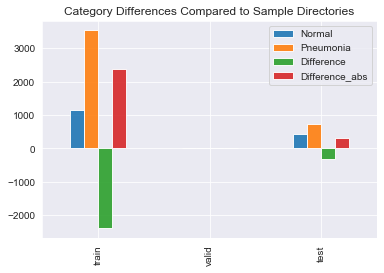

In [11]:
#locations = [0, 1, 2}
x_labels = ['Train', 'Valid', 'Test']
#fig = plt.figure()
#ax = fig.add_subplot(1,1,1)
#labels = ax.set_xticklabels(x_labels, rotation=70, fontsize='small')
#plt.bar(locations, tick_label=labels, alpha=0.8) # hights, color=colors, width,
#plt.title('Category Differences Compared to Sample Directories', fontsize=15)

df_categories.plot(title='Category Differences Compared to Sample Directories', kind='bar', tick_label=x_labels, alpha=0.9)

The training set (x label: train) has much moch pneumonia cases campare to the normal ones, this is not the case for the testing samples (x label: test) of normal and pneumonia chest images. They look much more balanced. The validation samples (x label: valid) are very small and the same for the normal and pneumonia set (only 8 each). So, this columns are empty in the diagrams.

**Additional question** regarding the different sample directories: How many of the pneumonia chest images have virus or bacteria as _root cause_?

In [12]:
def get_rootcause_counter(files):
    ''' delivers the amount of bacteria or virus pneumonia images '''
    counter_virus = 0
    counter_bacteria = 0
    file_array = files
    
    
    for item in file_array:
        if 'virus' in item:
            counter_virus += 1
        elif 'bacteria' in item:
            counter_bacteria += 1
        else:
            print('{} does not include a root cause in its file name string (virus or bac.')
            
    return counter_virus, counter_bacteria

count_train_virus, count_train_bacteria = get_rootcause_counter(train_pneumonia_files)
count_valid_virus, count_valid_bacteria = get_rootcause_counter(valid_pneumonia_files)
count_test_virus, count_test_bacteria = get_rootcause_counter(test_pneumonia_files)

print("--- Train pneumonia files ---")        
print("{} virus chest images.".format(count_train_virus))
print("{} bacteria chest images.".format(count_train_bacteria))

print("\n--- Validation pneumonia files ---")        
print("{} virus chest images.".format(count_valid_virus))
print("{} bacteria chest images.".format(count_valid_bacteria))

print("\n--- Test pneumonia files ---")        
print("{} virus chest images.".format(count_test_virus))
print("{} bacteria chest images.".format(count_test_bacteria))

--- Train pneumonia files ---
1235 virus chest images.
2293 bacteria chest images.

--- Validation pneumonia files ---
5 virus chest images.
11 bacteria chest images.

--- Test pneumonia files ---
253 virus chest images.
476 bacteria chest images.


**Note:**<br>
In the future, having more pneumonia chest images with further root causes (not only virus and bacteria root causes exist), the algorithm can be improved doing a multi-class classification between normal and pneumonia ones, where the pneumonia ones are differentiated by their root cause from the scratch.

<a id='step3'></a>
## Step 3: Data Pre-Processing

Keras is using TensorFlow as backend, means as tensor manipulation. According the TensorFlow [guide](https://www.tensorflow.org/guide/tensors), a "tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes." 

Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  


The `path_to_tensor` function below takes a string-valued file path to a grey-scale chest image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with grey-scale images, each image has one [channel](https://www.tensorflow.org/api_docs/python/tf/summary/image).  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 1).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 1).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset.

In [5]:
def path_to_tensor(img_path):
    # loads grey-scale image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale the images by dividing every pixel in every image by 255.

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████████████████████████████████| 1152/1152 [02:24<00:00,  7.95it/s]


<a id='step4'></a>
## Step 4: Create a CNN Model from the Scratch (Basic Model)

### Model Implementation

Start creating a basic model with 5 blocks of Convolutional, MaxPooling and Dropout sublayers as hidden layer components. As flatten layer GlobalAveragePooling2D is used. The output Dense layer for the 2 resulting categories NORMAL and PNEUMONIA is using 'softmax' as activation function.

In [7]:
# Define the base model architecture.

# Start with the basic model
base_model_class = Model("Basic", "Basic_CNN_Model", "accuracy")
base_model = base_model_class.get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
______________________________________

### Compile the Model

As optimiser 'rmsprop' with loss function 'binary_crossentropy' and 'accuracy' metric is used. The weights of the model layers will be updated during training.

In [8]:
base_model_class = base_model_class.get_class()
# Is it the expected class?
base_model_class

In [9]:
base_model_class.compile_model(model=base_model, optimizer='rmsprop',
                               loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model

Model training with use of checkpointing to save the model that attains the best validation loss. The following hyperparameters are set: 
- `epochs` is set to a number of iterations including the point where the network stops learning or start overfitting (20)
- `batch_size` is set to a common minimal size of memory: 32; if your machine is better use 64, 128, 256, ... 

For the original dataset: train on 5216 samples, therefore batch_size=32 => 5216/32 = 163<br>
For the modified dataset: train on 146 x 32 = 4672 samples  (same batch size of 32)

In [22]:
# specify the number of epochs used to train the model

# regarding the original dataset: 
# train on 5216 samples, therefore batch_size=32 => 5216/32 = 163
# first training started with epochs=20, but after epochs=10 no improvement, therefore changed to 15 

# with modified dataset: start again with 20 epochs and 32 batches, then reduced to 15

base_model_history = base_model_class.train_model(model=base_model, epochs=15, batch_size=32,
                                           filepath='./saved_models/base_model_weights.best.from_scratch.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Instructions for updating:
Use tf.cast instead.
Train on 4672 samples, validate on 32 samples
Epoch 1/20
 - 814s - loss: 0.5129 - acc: 0.7663 - val_loss: 1.0708 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.07083, saving model to ./saved_models/base_model_weights.best.from_scratch.hdf5
Epoch 2/20
 - 720s - loss: 0.3656 - acc: 0.8142 - val_loss: 1.1090 - val_acc: 0.5938

Epoch 00002: val_loss did not improve from 1.07083
Epoch 3/20
 - 798s - loss: 0.3435 - acc: 0.8307 - val_loss: 0.9913 - val_acc: 0.6562

Epoch 00003: val_loss improved from 1.07083 to 0.99129, saving model to ./saved_models/base_model_weights.best.from_scratch.hdf5
Epoch 4/20
 - 797s - loss: 0.3291 - acc: 0.8487 - val_loss: 0.8974 - val_acc: 0.6875

Epoch 00004: val_loss improved from 0.99129 to 0.89743, saving model to ./saved_models/base_model_weights.best.from_scratch.hdf5
Epoch 5/20
 - 797s - loss: 0.3134 - acc: 0.8632 - val_loss: 1.1896 - val_acc: 0.6562

Epoch 00005: val_loss did not improve from

### Load the Model with the Best Validation Loss

In [10]:
base_model_class.load_best_weights(model=base_model,
                                   filepath='./saved_models/base_model_weights.best.from_scratch.hdf5')

In [24]:
# plot the base model to a file and store it for further usage
plot_model(base_model, to_file='./saved_models/base_model.png')

### Test the Model

Try out this basic model on the test chest images dataset.  What is its test accuracy?

In [19]:
# get index of predicted pneumonia for each image in the testset
base_model = base_model_class.get_model()
chest_pneumonia_predictions = [np.argmax(base_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(chest_pneumonia_predictions) == np.argmax(test_targets, axis=1))/ \
                                                                        len(chest_pneumonia_predictions)
print('Basic Model Test Accuracy: %.3f%%' % test_accuracy)

Basic Model Test Accuracy: 85.677%


### Metrics of the Model

Calculates and shows several metrics of this **basic model**. Start with evaluated classification accuracy for training and testing (must be the same as before, only as a decimal number instead of percentage).

**Accuracy** is the correctness of the binary classification: it measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions 

(TP + TN) / (TP + TN + FP + FN)

where: TP = TruePositive; FP = FalsePositive; TN = TrueNegative; FN = FalseNegative 

In [26]:
_, train_acc = base_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, test_acc = base_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the basic model:")
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Accuracy for training and testing of the basic model:
Train: 0.861, Test: 0.857


#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

In [7]:
# show the history diagram for epochs and associated accuracy results (coding of the Keras documentation)
def show_history_accuracy(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

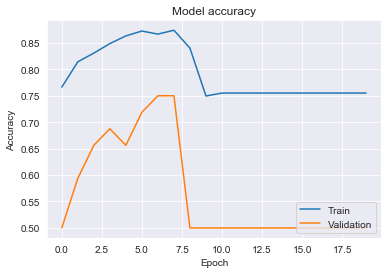

In [28]:
# base_model_history is the resulting instance of the base model fit() function
show_history_accuracy(base_model_history)

**Note:**<br>
Regarding the result of the original dataset:<br>
The training curve is much higher compared to the validation one, means overfitting exists. And with Epoch 6 both accuracy lines went down completely. According [Neural Network  FAQ](ftp://ftp.sas.com/pub/neural/FAQ3.html#A_over) "Overfitting is especially dangerous because it can easily lead to predictions that are far beyond the range of the training data with many of the common types of NNs. Overfitting can also produce wild predictions in multilayer perceptrons even with noise-free data." In other words, with overfitting our predictions are not reliable. In the mentioned FAQ several reasons and approaches to avoid overfitting are mentioned.<br>
In this project as one consequence the Keras Adam optimiser with decay is used and additionally the augmentation concept to get much more training images which fits better to the amount of training parameters of the network.

#### Learning during Training

Show the learning curves of loss function for training and validation.

In [8]:
# Show the training & validation loss values (learning)
def show_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

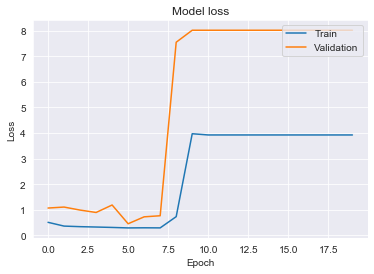

In [30]:
# base_model_history is the resulting instance of the base model fit() function
show_history_loss(base_model_history)

**Note:**<br>
In general, the training loss is the average of the losses over each batch of training data. There are 32 samples in each batch, which are processed independently. The model 'learns' over time, so regarding an epoch, at the beginning the learning loss value from the first batch is higher compared to the loss value of the final batch at the end. During validation, only the loss value of the epochs end is created, means a lower value shall exist. 

We see overfitting as well, with Epoch 7 it is complete and both learning curves are unchanged at their maximum. Both diagrams show, that the model does not fit perfectly to the classification problem. In the next project parts, we will have a look, if a better fitting network architecture exists.

#### But first, some other metrics needed to compare all model results during the benchmark chapter ...

**Precision** quantifies the binary precision. It is a ratio of true positives (images classified as pneumonia ones, and which are actually pneumonia) to all positives (all images classified as pneumonia ones, irrespective of whether that was the correct classification), in other words it is theratio of

TruePositives / (TruePositives + FalsePositives)

**Recall (sensitivity)** tells us what proportion of images that actually were pneumonia ones were classified by us as pneumonis ones. It is a ratio of true positives to all the images that were actually pneumonia ones, in other words it is the ratio of

TruePositives / (TruePositives + FalseNegatives)

A model's ability to precisely predict those that have a pneumonia is more importantthan themodel's ability to recall those individuals. We can use **F-beta score** as a metric that considers both precision and recall. According scikit-learn, the F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0. F – Measure is nothing but the harmonic mean of Precision and Recall.

Fβ=(1 + β2)  (precision⋅recall / ((β2⋅precision) + recall))

In particular, when β=0.5, more emphasis is placed on precision.

In [ ]:
# The scikit-learn metrics API expects a 1D array of actual and predicted values for comparison,
# therefore we must reduce the 2D target arrays to 1D arrays.
# How do the data arrays look like? 
#test_targets[:,1]
#chest_pneumonia_predictions

In [9]:
# some other metrics ...

def get_other_metrics(test_targets, chest_pneumonia_predictions):
    ''' 
    Delivers textual prints of several metrics:
    precision, recall, f1 score, f-beta score with beta 0.5, 
    Cohens Kappa and confusion matrix
    '''
    
    # precision: tp / (tp + fp)
    precision = metrics.precision_score(test_targets[:,1], chest_pneumonia_predictions)
    print('Precision: %.3f' % precision)
    # recall: tp / (tp + fn)
    recall = metrics.recall_score(test_targets[:,1], chest_pneumonia_predictions)
    print('Recall: %.3f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = metrics.f1_score(test_targets[:,1], chest_pneumonia_predictions)
    print('F1 score: %.3f' % f1)
    # f-beta score
    f_beta = metrics.fbeta_score(test_targets[:,1], chest_pneumonia_predictions, average = 'weighted', beta=0.5)
    print('F-beta score: %.3f  with beta=0.5' % f_beta)

    print()
    # kappa
    kappa = metrics.cohen_kappa_score(test_targets[:,1], chest_pneumonia_predictions)
    print('Cohens kappa: %.3f' % kappa)
    # confusion matrix
    matrix = metrics.confusion_matrix(test_targets[:,1], chest_pneumonia_predictions)
    print('Confusion matrix:\n{}'.format(matrix))

In [32]:
get_other_metrics(test_targets, chest_pneumonia_predictions)

Precision: 0.930
Recall: 0.837
F1 score: 0.881
F-beta score: 0.863  with beta=0.5

Cohens kappa: 0.703
Confusion matrix:
[[377  46]
 [119 610]]


**Note:**<br>
Regarding this metrics some more explanations:

- **Cohen's Kappa**


- **Confusion matrix**<br>
  In general its architecture looks like
  ![confusion matrix](./images/ConfusionMatrix_architecture.png)

  Regarding the original dataset:<br>
  So, for this basic model we have 184 true positives and 39 false negatives and on the other hand, 351 true negatives and 50 false positives. The false negatives are too much (type 2 error). This should be improved. We will see how this values change using different models compared to this basic one.
  
  
- **Type 1 and Type 2 Errors**<br>
  There are two types of errors that can be identified here:

    Type 1 Error: The model predicted the instance to be a Positive class, but it is incorrect. This is False Positive (FP).<br>
    Type 2 Error: The model predicted the instance to be the Negative class, but it is incorrect. This is False Negative (FN).


In [33]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = base_model.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of basic model: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model: 0.922


**Note:**<br>
The ROC – Receiver operating characteristic - curve is a curve between true positive rate and false positive rate for various threshold values. It informs us how good or bad our model performance is. The more the area under the curve (AUC), the better is the performance of our model to distinguish the classes. Means, it is a prediction probability curve for the different classes.

A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis. And the ideal value for AUC is 1. In general, such best case scenario will not be reached, means we don't have a clear distinction between the two classes NORMAL and PNEUMONIA. In other words, we have some overlapping of the class predictions and that introduces Type 1 and Type 2 errors to the model prediction. Regarding the AUC value it will be to be between 0.5 and 1. In general, the diagnoal line visualises the random prediction.

In our case, we are looking to the 'positive' Pneumonia class. So, how does the ROC AUC diagram looks like to the given ROC AUC value above?

In [10]:
# Plot the ROC AUC diagram for Pneumonia;
def plot_ROC_AUC(fpr, tprm, modelname):
    
    print("--- associated ROC AUC diagram of model type {} ---".format(modelname))
    plt.plot(fpr, tpr, color='red')
    plt.title('Receiver Operating Characteristic Curve', size=15)
    plt.plot([0, 1], [0, 1], color='green', linestyle=':')
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.show()

--- associated ROC AUC diagram of model type Basic CNN Model ---


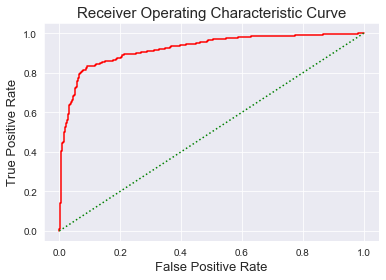

In [35]:
# see:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "Basic CNN Model")

<a id='step5'></a>
## Step 5 Last Basic Model with Augmentation

### Model Implementation and Training

We are using image data augmentation to decrease the amount of images of our training dataset. This concept shall improve the performance and the generalisation ability of our network. We want to prevent overfitting. Keras offers already a process to do this, using its ImageDataGenerator object class. The original images are rotated, shifted, zoomed, flipped etc. and by doing this, creating new image mutations.

Generator handling according the given Keras example using .flow() functionality together with the already created pre-processed tensors instances. With such tensors rescaling by /255 has already happened. The .flow() command generates batches of randomly transformed images.

The generator parameters are set according the image properties, having chest images. E.g. huge zooming or rotation would make no sense, but horizontal flip is fine. 

In general according augmentation information, have a look to the associated Keras classification [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [19]:
train_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    rescale=1.,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

validation_generator = ImageDataGenerator(rescale=1)

In [20]:
batch_size = 32
training_data = train_data_generator.flow(train_tensors, train_targets, batch_size=batch_size)
validation_data = validation_generator.flow(valid_tensors, valid_targets, batch_size=batch_size)

In [13]:
epochs = 15  # first try: 15 because of insights from former models
augm_base_model_history = base_model_class.augmentation_train_model(model=base_model,
                                  filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 326s - loss: 0.5229 - acc: 0.7695 - val_loss: 1.0391 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 1.03908, saving model to ./saved_models/base_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 325s - loss: 3.5012 - acc: 0.7444 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 1.03908
Epoch 3/15
 - 307s - loss: 3.9252 - acc: 0.7551 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 1.03908
Epoch 4/15
 - 364s - loss: 3.9252 - acc: 0.7551 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 1.03908
Epoch 5/15
 - 319s - loss: 3.9252 - acc: 0.7551 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 1.03908
Epoch 6/15
 - 313s - loss: 3.9252 - acc: 0.7551 - val_loss: 8.0151 - val_acc: 0.5000

Epoch 00006: val_loss did not improve from 1.03908
Epoch 7/15
 - 335s - loss: 3.9252 - acc: 0.7551 - va

### Load the Model with the Best Validation Loss

In [14]:
base_model_class.load_best_weights(model=base_model,
                                   filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5')

### Test the Model

In [15]:
# get index of predicted pneumonia for each image in the testset
augm_base_model = base_model_class.get_model()
augm_chest_pneumonia_predictions = [np.argmax(augm_base_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(augm_chest_pneumonia_predictions) == np.argmax(test_targets, axis=1))/ \
                                                                           len(augm_chest_pneumonia_predictions)
print('Basic Model with Augmentation: its Test Accuracy: %.3f%%' % test_accuracy)

Basic Model with Augmentation: its Test Accuracy: 79.167%


### Metrics of the Model

In [16]:
_, augm_base_train_acc = augm_base_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, augm_base_test_acc = augm_base_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the basic model with Augmentation:")
print('Train: %.3f, Test: %.3f' % (augm_base_train_acc, augm_base_test_acc))

Accuracy for training and testing of the basic model with Augmentation:
Train: 0.851, Test: 0.792


#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

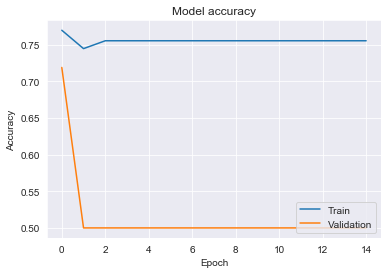

In [21]:
show_history_accuracy(augm_base_model_history)

#### Learning during Training

Show the learning curves of loss function for training and validation.

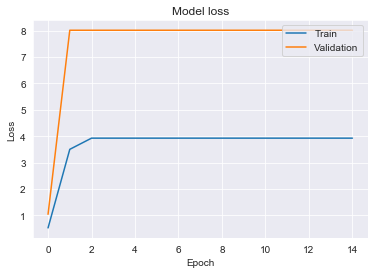

In [22]:
show_history_loss(augm_base_model_history)

#### Some other Metrics

In [23]:
get_other_metrics(test_targets, augm_chest_pneumonia_predictions)

Precision: 0.773
Recall: 0.949
F1 score: 0.852
F-beta score: 0.786  with beta=0.5

Cohens kappa: 0.511
Confusion matrix:
[[220 203]
 [ 37 692]]


In [24]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = augm_base_model.predict(test_tensors, verbose=0)  # arrays: chest normal & pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of basic model with Augmentation: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with Augmentation: 0.912


--- associated ROC AUC diagram of model type Basic CNN Model with Augmentation ---


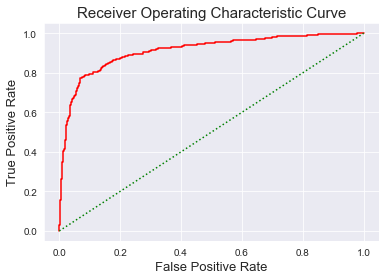

In [26]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "Basic CNN Model with Augmentation")

<a id='step6'></a>
## Step 6: Such Basic Model with Adam as Optimiser

### Compile and Train the Model

In [27]:
# Start creating as new instance with the basic model
adam_base_model_class = Model("Basic", "Basic_CNN_Model", "accuracy")
adam_base_model = adam_base_model_class.get_model()


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)          

In [29]:
# adam defaults:
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# learn with decay to avoid overfitting, decay=1e-6
adam_base_model_class = adam_base_model_class.get_class()
#print(adam_base_model_class)
adam_base_model_class.set_Adam_params()
adam_base_model_class.compile_model(model=base_model, optimizer='Adam', loss='binary_crossentropy',
                                    metrics=['accuracy'])
adam_base_model = adam_base_model_class.get_model()
#adam_base_model

In [30]:
# train the model with call of train function
# because of experiences of former trainings where improvements happened at the end of the 15 epochs,
# now the epochs value is set to 20
Adam_base_model_history = adam_base_model_class.train_model(model=adam_base_model, epochs=20, batch_size = 32,
                                  filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5',
                                  train_tensors=train_tensors, train_targets=train_targets,
                                  valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 4672 samples, validate on 32 samples
Epoch 1/20
 - 806s - loss: 0.2769 - acc: 0.8823 - val_loss: 0.8019 - val_acc: 0.7812

Epoch 00001: val_loss improved from inf to 0.80191, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 2/20
 - 793s - loss: 0.2255 - acc: 0.9071 - val_loss: 0.6530 - val_acc: 0.7188

Epoch 00002: val_loss improved from 0.80191 to 0.65296, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 3/20
 - 804s - loss: 0.2003 - acc: 0.9187 - val_loss: 0.5213 - val_acc: 0.6562

Epoch 00003: val_loss improved from 0.65296 to 0.52127, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 4/20
 - 819s - loss: 0.1991 - acc: 0.9170 - val_loss: 0.6518 - val_acc: 0.7188

Epoch 00004: val_loss did not improve from 0.52127
Epoch 5/20
 - 847s - loss: 0.1962 - acc: 0.9197 - val_loss: 0.3184 - val_acc: 0.8438

Epoch 00005: val_loss improved from 0.52127 to 0.31838, saving 

### Load the Model with the Best Validation Loss

In [31]:
base_model_class.load_best_weights(model=adam_base_model,
                                   filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5')

### Test the Model

In [32]:
# get index of predicted pneumonia for each image in the testset
adam_base_model = base_model_class.get_model()
Adam_chest_pneumonia_predictions = [np.argmax(adam_base_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(Adam_chest_pneumonia_predictions) == np.argmax(test_targets, axis=1))/ \
                                                                           len(Adam_chest_pneumonia_predictions)
print('Basic Model with Adam optimiser: its Test Accuracy: %.3f%%' % test_accuracy)

Basic Model with Adam optimiser: its Test Accuracy: 88.455%


### Metrics of the Model

Calculates and shows several metrics of this **basic model with Adam optimiser**.

In [33]:
_, Adam_base_train_acc = adam_base_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, Adam_base_test_acc = adam_base_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the basic model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (Adam_base_train_acc, Adam_base_test_acc))

Accuracy for training and testing of the basic model with Adam optimiser:
Train: 0.954, Test: 0.885


#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

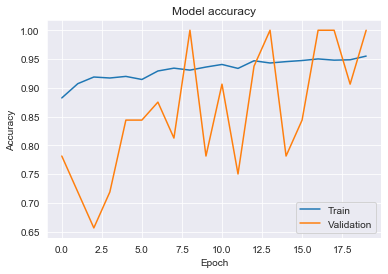

In [34]:
# Adam_base_model_history is the resulting instance of the models fit() function
show_history_accuracy(Adam_base_model_history)

**Note:**<br>
Second try with original dataset:<br>
The training set is still much better compared to the validation set, means there is still overfitting, but now starting with epoch 12 the validation line improves getting better accuracy. So, it could be with a higher epoch value of 20 or 30 that there is an intersection point where we know we have to stop the training.

First try with modified dataset:<br>
The general results of this dataset using 20 epochs looks much better. Such huge overfitting as before is not available.

#### Learning during Training

Show the learning curves of loss function for training and validation.

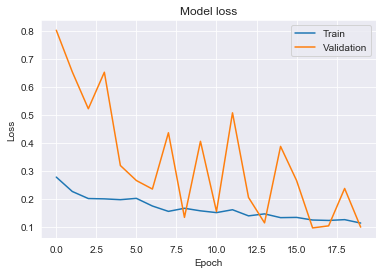

In [35]:
show_history_loss(Adam_base_model_history)

#### Some other Metrics

In [36]:
get_other_metrics(test_targets, Adam_chest_pneumonia_predictions)

Precision: 0.871
Recall: 0.960
F1 score: 0.913
F-beta score: 0.884  with beta=0.5

Cohens kappa: 0.742
Confusion matrix:
[[319 104]
 [ 29 700]]


In [37]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = adam_base_model.predict(test_tensors, verbose=0)  # arrays: chest normal & pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of basic model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with Adam optimiser: 0.954


--- associated ROC AUC diagram of model type Basic CNN Model with Adam optimiser ---


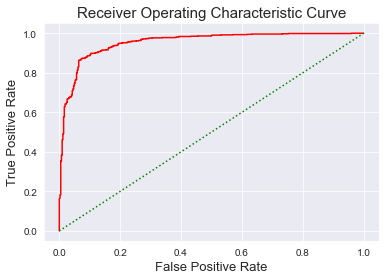

In [38]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "Basic CNN Model with Adam optimiser")

**Note:**<br>
.......

<a id='step7'></a>
## Step 7: Last Basic Model with Adam and Augmentation

### Model Implementation and Training

We are using image data augmentation to decrease the amount of images of our training dataset. This concept shall improve the performance and the generalisation ability of our network. We want to prevent overfitting. Keras offers already a process to do this, using its ImageDataGenerator object class. The original images are rotated, shifted, zoomed, flipped etc. and by doing this, creating new image mutations.

Generator handling according the given Keras example using .flow() functionality together with the already created pre-processed tensors instances. With such tensors rescaling by /255 has already happened. The .flow() command generates batches of randomly transformed images.

The generator parameters are set according the image properties, having chest images. E.g. huge zooming would make no sense, but horizontal and vertical flip is fine.

In general according augmentation information, have a look to the associated Keras classification [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [39]:
# first try with original dataset: 20 because of insights from former models, but has no effect
# therefore first try with modified dataset: 15 epochs
epochs = 15

# use the same generator instance and flow data as before ...
# valid_tensors.shape[0] -> original dataset: 16 / 32 = 0.5;  modified dataset: 32 / 32 = 1 
Adam_base_model_aug_history = base_model_class.augmentation_train_model(model=adam_base_model,
                                  filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/15
 - 386s - loss: 0.2884 - acc: 0.8816 - val_loss: 0.1799 - val_acc: 0.9062

Epoch 00001: val_loss improved from inf to 0.17986, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 306s - loss: 0.2530 - acc: 0.8902 - val_loss: 0.1770 - val_acc: 0.9375

Epoch 00002: val_loss improved from 0.17986 to 0.17696, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 3/15
 - 377s - loss: 0.2401 - acc: 0.8994 - val_loss: 0.4004 - val_acc: 0.8125

Epoch 00003: val_loss did not improve from 0.17696
Epoch 4/15
 - 361s - loss: 0.2346 - acc: 0.9024 - val_loss: 0.1817 - val_acc: 0.9375

Epoch 00004: val_loss did not improve from 0.17696
Epoch 5/15
 - 331s - loss: 0.2374 - acc: 0.8990 - val_loss: 0.3120 - val_acc: 0.8438

Epoch 00005: val_loss did not improve from 0.17696
Epoch 6/15
 - 344s - loss: 0.2308 - acc: 0.9056 - val_loss: 0.3500 - val_acc: 0.8438

Epoch 00006: val_loss did not improve from 0.17696
Epoch 7/

### Load the Model with the Best Validation Loss

In [40]:
base_model_class.load_best_weights(model=adam_base_model,
                                   filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5')

### Model Testing

In [41]:
# get index of pneumonia prediction for each image in test set
adam_base_model = base_model_class.get_model()
chest_pneumonia_predict_withAdamAug = [np.argmax(adam_base_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_acc_withAdamAug = 100*np.sum(np.array(chest_pneumonia_predict_withAdamAug)==np.argmax(test_targets, axis=1))/ \
                                                                       len(chest_pneumonia_predict_withAdamAug)
print('Base model test accuracy with Adam optimiser and Augmentation: %.3f%%' % test_acc_withAdamAug)

Base model test accuracy with Adam optimiser and Augmentation: 90.104%


### Metrics of the Model

Calculates and shows several metrics of this **basic, augmented model with Adam optimiser**. Start with evaluated classification accuracy for training and testing (must be the same as before, only as a decimal number instead of percentage).

In [42]:
_, Adam_aug_train_acc = adam_base_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, Adam_aug_test_acc = adam_base_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the basic, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (Adam_aug_train_acc, Adam_aug_test_acc))

Accuracy for training and testing of the basic, augmented model with Adam optimiser:
Train: 0.941, Test: 0.901


#### Accuracy during Training

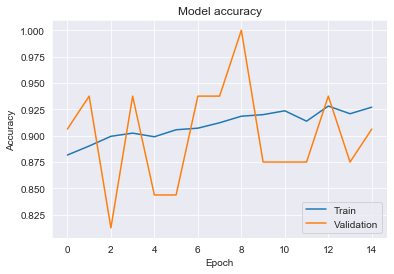

In [43]:
show_history_accuracy(Adam_base_model_aug_history)

#### Learning during Training

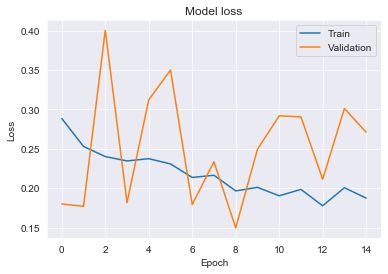

In [44]:
show_history_loss(Adam_base_model_aug_history)

#### Some other Metrics

In [45]:
get_other_metrics(test_targets, chest_pneumonia_predict_withAdamAug)

Precision: 0.894
Recall: 0.957
F1 score: 0.925
F-beta score: 0.901  with beta=0.5

Cohens kappa: 0.781
Confusion matrix:
[[340  83]
 [ 31 698]]


In [46]:
# ROC AUC
# predict probabilities for test set
yhat_probs = adam_base_model.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) # pneumonia probability values
# auc = metrics.roc_auc_score(test_targets, yhat_probs)
print('ROC AUC Pneumonia class prediction of base, augmented model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of base, augmented model with Adam optimiser: 0.969


--- associated ROC AUC diagram of model type Basic CNN Model with augmentation and Adam optimiser ---


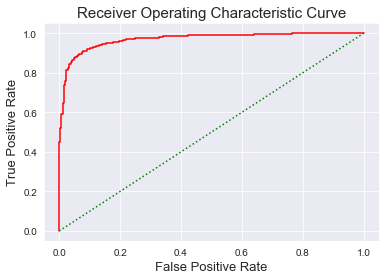

In [47]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "Basic CNN Model with augmentation and Adam optimiser")

**Note:**<br>
Original dataset: Regarding the first try from 2019-07-08:<br>
As a whole, augmentation has improved the basic model. All metrics are much higher, its test accuracy improves from 85.256% up to 90.064% and the learning curve decreases fast from epoch 1 to epoch 5.

Modified dataset: There is a small improvement with augmentation compared to the first training with Adam optimizer. Its ROC AUC value is the best by now with 0.969.

<a id='step8'></a>
## Step 8: Create an improved CNN Model with Adam

Now, we train a model having more hidden layers - a more complex architecture - using Adam as optimiser at once, what kind of result will be calculated compared to the last basic model after having done the augmentation improvement? The Adam optimiser is used for learning with binary crossentropy loss function.

Afterwards, we apply the augmentation concept on this improved model and see what kind of performance difference will appear.

To know more about improved model architectures the following [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf) is available:
'Going Deeper with Convolutions'


### Model Implementation

In [48]:
# Define the improved model architecture.
improved_model_class = Model("Improved", "Improved_CNN_Model", "accuracy")
improved_model = improved_model_class.get_model()


--- Build model summary of Improved_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)    

### Compile the Model

In [49]:
improved_model_class = improved_model_class.get_class()
improved_model_class

In [50]:
# first try: use Adam optimiser with same decay as basic model, decay=1e-6 
improved_model_class.set_Adam_params()
improved_model_class.compile_model(model=improved_model, optimizer='Adam', loss='binary_crossentropy',
                                   metrics=['accuracy'])

### Train the Model

In [51]:
epochs = 20   # first try: epochs 20
batch_size = 32
improved_model_adam = improved_model_class.get_model()
improved_model_history = improved_model_class.train_model(model=improved_model_adam,
                                           epochs=epochs, batch_size=batch_size,
                                           filepath='./saved_models/improved_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 4672 samples, validate on 32 samples
Epoch 1/20
 - 1678s - loss: 0.5423 - acc: 0.7539 - val_loss: 3.5267 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 3.52669, saving model to ./saved_models/improved_model_weights.best.withAdam.hdf5
Epoch 2/20
 - 1432s - loss: 0.3955 - acc: 0.7832 - val_loss: 0.6680 - val_acc: 0.7188

Epoch 00002: val_loss improved from 3.52669 to 0.66795, saving model to ./saved_models/improved_model_weights.best.withAdam.hdf5
Epoch 3/20
 - 1191s - loss: 0.3380 - acc: 0.8519 - val_loss: 0.7651 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.66795
Epoch 4/20
 - 1067s - loss: 0.3152 - acc: 0.8555 - val_loss: 0.8775 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.66795
Epoch 5/20
 - 1081s - loss: 0.2982 - acc: 0.8677 - val_loss: 0.6901 - val_acc: 0.7500

Epoch 00005: val_loss did not improve from 0.66795
Epoch 6/20
 - 973s - loss: 0.2762 - acc: 0.8786 - val_loss: 0.4708 - val_acc: 0.7500

Epoch 00006: val_loss impr

### Load the Model with the Best Validation Loss

In [52]:
improved_model_class.load_best_weights(model=improved_model_adam,
                                       filepath='./saved_models/improved_model_weights.best.withAdam.hdf5')

In [53]:
# plot the improved model to a file and store it for further usage
plot_model(improved_model_adam, to_file='./saved_models/improved_model_withAdam.png')

### Model Testing

In [54]:
# get index of pneumonia prediction for each image in test set
improved_model_adam = improved_model_class.get_model()
chest_pneumonia_predict_impr_adam = [np.argmax(improved_model_adam.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_acc_impr_adam = 100*np.sum(np.array(chest_pneumonia_predict_impr_adam)==np.argmax(test_targets, axis=1))/ \
                                                                    len(chest_pneumonia_predict_impr_adam)
print('Improved model test accuracy with Adam optimiser: %.3f%%' % test_acc_impr_adam)

Improved model test accuracy with Adam optimiser: 88.542%


### Metrics of the Model

Calculates and shows several metrics of this **improved model with Adam optimiser**.

In [55]:
_, improved_train_acc_adam = improved_model_adam.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, improved_test_acc_adam = improved_model_adam.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the improved model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc_adam, improved_test_acc_adam))

Accuracy for training and testing of the improved model with Adam optimiser:
Train: 0.975, Test: 0.885


#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

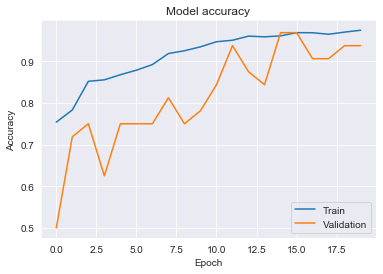

In [56]:
show_history_accuracy(improved_model_history)

#### Learning during Training

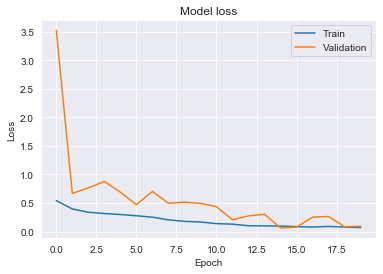

In [57]:
show_history_loss(improved_model_history)

#### Some other Metrics

In [58]:
get_other_metrics(test_targets, chest_pneumonia_predict_impr_adam)

Precision: 0.865
Recall: 0.970
F1 score: 0.915
F-beta score: 0.886  with beta=0.5

Cohens kappa: 0.742
Confusion matrix:
[[313 110]
 [ 22 707]]


In [59]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model_adam.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) # pneumonia probability values
# auc = metrics.roc_auc_score(test_targets, yhat_probs)
print('ROC AUC Pneumonia class prediction of improved model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of improved model with Adam optimiser: 0.937


--- associated ROC AUC diagram of model type Improved CNN Model with Adam optimiser ---


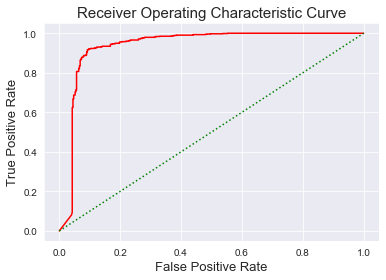

In [60]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "Improved CNN Model with Adam optimiser")

**Note:**<br>
......

<a id='step9'></a>
## Step 9:  Last improved CNN Model with Augmentation

### Training with Augmentation

In [62]:
epochs = 20
batch_size = 32
# generator and generator flow data, training and validation data are the same as before
improved_model_aug_history = improved_model_class.augmentation_train_model(model=improved_model,
                                filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5', 
                                training_data=training_data, validation_data=validation_data,
                                epochs=epochs, batch_size=batch_size,
                                train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/20
 - 1243s - loss: 0.3063 - acc: 0.8639 - val_loss: 0.1681 - val_acc: 0.9375

Epoch 00001: val_loss improved from inf to 0.16806, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 2/20
 - 859s - loss: 0.2502 - acc: 0.8928 - val_loss: 0.2530 - val_acc: 0.9062

Epoch 00002: val_loss did not improve from 0.16806
Epoch 3/20
 - 934s - loss: 0.2606 - acc: 0.8842 - val_loss: 0.1943 - val_acc: 0.9688

Epoch 00003: val_loss did not improve from 0.16806
Epoch 4/20
 - 741s - loss: 0.2487 - acc: 0.8911 - val_loss: 0.2155 - val_acc: 0.9375

Epoch 00004: val_loss did not improve from 0.16806
Epoch 5/20
 - 1048s - loss: 0.2215 - acc: 0.9035 - val_loss: 0.2706 - val_acc: 0.8750

Epoch 00005: val_loss did not improve from 0.16806
Epoch 6/20
 - 1244s - loss: 0.2367 - acc: 0.9033 - val_loss: 0.1709 - val_acc: 0.9688

Epoch 00006: val_loss did not improve from 0.16806
Epoch 7/20
 - 1188s - loss: 0.2217 - acc: 0.9075 - val_loss: 0.2487 - val_acc: 0.9062

Epoch 

### Load the Model with the Best Validation Loss

In [63]:
improved_model_class.load_best_weights(model=improved_model,
                                  filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5')

### Improved Model Testing

In [64]:
# get index of pneumonia prediction for each image in test set
improved_model = improved_model_class.get_model()
improved_chest_pneumonia_predict_aug = [np.argmax(improved_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
improved_test_acc = 100*np.sum(np.array(improved_chest_pneumonia_predict_aug)==np.argmax(test_targets, axis=1))/ \
                                                                            len(improved_chest_pneumonia_predict_aug)
print('Improved model test accuracy with Adam optimiser and Augmentation: %.3f%%' % improved_test_acc)

Improved model test accuracy with Adam optimiser and Augmentation: 92.622%


### Metrics of the Model

Calculates and shows several metrics of this **improved, augmented model with Adam optimiser**. Start with evaluated classification accuracy for training and testing (must be the same as before, only as a decimal number instead of percentage).

In [65]:
_, improved_train_acc = improved_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, improved_test_acc = improved_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the improved, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc, improved_test_acc))

Accuracy for training and testing of the improved, augmented model with Adam optimiser:
Train: 0.937, Test: 0.926


#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

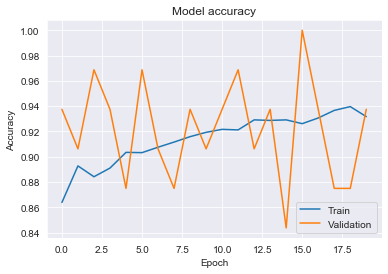

In [66]:
show_history_accuracy(improved_model_aug_history)

#### Learning during Training

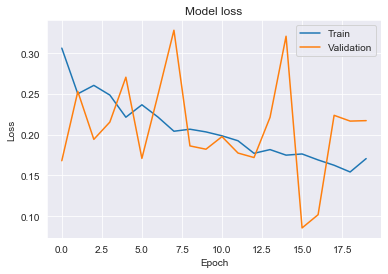

In [67]:
show_history_loss(improved_model_aug_history)

#### Some other Metrics

In [69]:
get_other_metrics(test_targets, improved_chest_pneumonia_predict_aug)

Precision: 0.946
Recall: 0.937
F1 score: 0.941
F-beta score: 0.926  with beta=0.5

Cohens kappa: 0.842
Confusion matrix:
[[384  39]
 [ 46 683]]


In [70]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) # pneumonia probability values
# auc = metrics.roc_auc_score(test_targets, yhat_probs)
print('ROC AUC Pneumonia class prediction of improved, augmented model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of improved, augmented model with Adam optimiser: 0.977


--- associated ROC AUC diagram of model type Improved CNN Model with augmentation and Adam optimiser ---


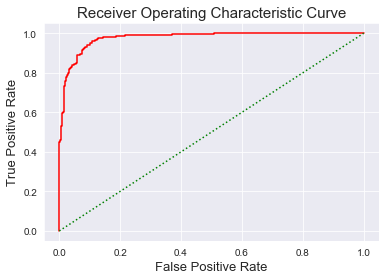

In [71]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "Improved CNN Model with augmentation and Adam optimiser")

**Note:**<br>
.......

<a id='step10'></a>
## Step 10: Create a Batch CNN Model from the Scratch

### Model Implementation and Compilation

Start creating a CNN model with some BatchNormalization and Dropout layers as hidden layers.<br>
As optimiser **Adam** is used with **binary_crossentropy** as loss (learning) function and for classification, default metric **accuracy** has been selected. 

In [11]:
batch_model_class = Model("Batch", "Batch_CNN_Model", "accuracy")
batch_model = batch_model_class.get_model()
batch_model_class = batch_model_class.get_class()
batch_model_class

Instructions for updating:
Colocations handled automatically by placer.

--- Build model summary of Batch_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 223, 223, 64)      16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 223, 223, 64)      256       
_________________________

In [12]:
# let's train the model using Adam with decay 1e-6 for each learning update
batch_model_class.set_Adam_params()
batch_model_class.compile_model(model= batch_model, loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Train the Model
Model training with use of checkpointing to save the model that attains the best validation loss. The same **epochs** and **batch_size** hyperparameter values are used. Now using BatchNormalization, batch_size has to be 32, because small values will decrease the classification performance.

In [ ]:
epochs = 20
batch_size = 32
batch_model_history = batch_model_class.train_model(model=batch_model,
                                              filepath='./saved_models/weights.best.from_scratch_batch.hdf5',
                                              train_tensors=train_tensors, train_targets=train_targets,
                                              valid_tensors=valid_tensors, valid_targets=valid_targets,
                                              epochs=epochs, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 4672 samples, validate on 32 samples
Epoch 1/20


### Load the Model with the Best Validation Loss

In [ ]:
batch_model_class.load_best_weights(model=batch_model, filepath='./saved_models/weights.best.from_scratch_batch.hdf5')

In [ ]:
# plot the batch model to a file and store it for further usage
plot_model(batch_model, to_file='./saved_models/batch_model.png')

### Batch Model Testing

In [ ]:
# get index of pneumonia prediction for each image in test set
batch_model = batch_model_class.get_model()
batch_chest_pneumonia_predict = [np.argmax(batch_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
batch_test_acc = 100*np.sum(np.array(batch_chest_pneumonia_predict)==np.argmax(test_targets, axis=1))/ \
                                                                            len(batch_chest_pneumonia_predict)
print('Batch model test accuracy with Adam optimiser: %.3f%%' % batch_test_acc)

### Metrics of the Model

In [ ]:
_, batch_train_acc = batch_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, batch_test_acc = batch_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the batch model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (batch_train_acc, batch_test_acc))

#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

In [ ]:
show_history_accuracy(batch_model_history)

#### Learning during Training

In [ ]:
show_history_loss(batch_model_history)

#### Some other Metrics

In [ ]:
get_other_metrics(test_targets, batch_model_history)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = batch_model.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of batch model with Adam optimiser: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "CNN Model with BatchNormalization and Adam optimiser")

**Note:**<br>
......

<a id='step11'></a>
## Step 11: Create a CNN Model with Transfer Learning

As sense of transfer learning, Goodfellow et al mentioned in their 'Deep Learning' book "Situation where what has been learned in one setting is exploited to improve generalization in another setting."

We don't have a huge dataset for the given pneumonia classification and more generalised, even not for all human age and X-ray orientation categories. The existing dataset is a specific one for a specific task, therefore we need technical help to improve the classification performance having a good, proper learning result, especially thinking at the 'new, available' image examples of the future.

With a pre-trained model, now, we use its knowledge even from another domain and task (like for image tasks an ImageNet database pre-trained model), to let our network learn the new problem. This knowledge transfer is possible, because all images share some same features, like edges or shapes.

Technically, how to do this is e.g. explained in the Keras [documentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), chapter part 'Fine-tuning the top layers of a a pre-trained network'.


### Model Implementation and Compilation


In [ ]:
# As pre-trained CNN InceptionV3 is selected
bottleneck_features = np.load('bottleneck_features/ChestInceptionV3Data.npz')
train_inceptV3 = bottleneck_features['train']
valid_inceptV3 = bottleneck_features['val']
test_inceptV3 = bottleneck_features['test']

In [ ]:
inceptV3_model_class = Model("Transfer", "Transfer_CNN_Model", "accuracy", train_inceptV3)
inceptV3_model = batch_model_class.get_model()
inceptV3_model_class = inceptV3_model.get_class()
inceptV3_model_class

In [ ]:
# let's train the model using Adam with decay 1e-6 for each learning update
inceptV3_model_class.set_Adam_params()
inceptV3_model_class.compile_model(model= inceptV3_model, loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Train the Model

In [ ]:
epochs = 20
batch_size = 32
transfer_model_history = inceptV3_model_class.train_model(model=inceptV3_model,
                                           filepath='./saved_models/weights.best.from_inceptV3_transfer.hdf5',
                                           train_tensors=train_inceptV3, train_targets=train_targets,
                                           valid_tensors=valid_inceptV3, valid_targets=valid_targets,
                                           epochs=epochs, batch_size=batch_size)

### Load the Model with the Best Validation Loss

In [ ]:
transfer_model_class.load_best_weights(model=inceptV3_model, filepath='./saved_models/weights.best.from_inceptV3_transfer.hdf5')

In [ ]:
# plot the transfer model to a file and store it for further usage
plot_model(inceptV3_model, to_file='./saved_models/inceptV3_transfer_model.png')

### Transfer Model Testing

In [ ]:
# get index of pneumonia prediction for each image in test set
inceptV3_model = inceptV3_model_class.get_model()
transfer_chest_pneumonia_predict = [np.argmax(inceptV3_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
transfer_test_acc = 100*np.sum(np.array(transfer_chest_pneumonia_predict)==np.argmax(test_targets, axis=1))/ \
                                                                          len(transfer_chest_pneumonia_predict)
print('InceptV3 transfer model test accuracy with Adam optimiser: %.3f%%' % transfer_test_acc)

### Metrics of the Model

In [ ]:
_, transfer_train_acc = batch_model.evaluate(train_inceptV3, train_targets, verbose=0)  # train X, train y
_, transfer_test_acc = batch_model.evaluate(test_inceptV3, test_targets, verbose=0)     # test X, test y
print("Accuracy for training and testing of the inceptionV3 transfer model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (transfer_train_acc, transfer_test_acc))

#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...

In [ ]:
show_history_accuracy(transfer_model_history)

#### Learning during Training

In [ ]:
show_history_loss(transfer_model_history)

#### Some other Metrics

In [ ]:
get_other_metrics(test_targets, transfer_model_history)

In [ ]:
# ROC AUC
# predict probabilities for test set
yhat_probs = inceptV3_model.predict(test_inceptV3, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of batch model with Adam optimiser: %.3f' % auc)

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
plot_ROC_AUC(fpr, tpr, "CNN Model with InceptV3 transfer learning and Adam optimiser")

**Note:**<br>
......

<a id='step12'></a>
## Step 12: Benchmark and Conclusion

sflasflsö